In [1]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sn

# Operations
import numpy as np
import pandas as pd 
import statsmodels.formula.api as sm
from tqdm import tqdm
import scipy.stats as ss

# Custom imports
from nlp_utilities.compling import CorpusUtilities
from src.utils import get_concreteness_for_word

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

In [30]:
# Set global variables
DATA_PATH = "data/raw/AoA_ratings_Kuperman_et_al_BRM.csv"
CHARACTER_INDEX	= 0
# Get data
df = pd.read_csv(DATA_PATH)
df['AoA_mean'] = df['Rating.Mean']

In [31]:
df.head(5)

,Word,OccurTotal,OccurNum,Freq_pm,Rating.Mean,Rating.SD,Dunno,AoA_mean
0,a,22.0,22.0,20415.27,2.89,1.21,1.00,2.89
1,aardvark,18.0,18.0,0.41,9.89,3.66,1.00,9.89
2,abacus,20.0,13.0,0.24,8.69,3.77,0.65,8.69
3,abalone,18.0,13.0,0.51,12.23,3.54,0.72,12.23
4,abandon,19.0,19.0,8.10,8.32,2.75,1.00,8.32


In [32]:
print("Number of words in dataset: {num}".format(num=len(df)))

# Drop duplicates
df = df.drop_duplicates(subset="Word")
print("Number of words left in dataset: {num}".format(num=len(df)))

# Drop NA
df = df.dropna()
print("Number of words left in dataset: {num}".format(num=len(df)))

# Drop NA rows
df = df.drop_duplicates(subset="Word")
print("Number of words left in dataset: {num}".format(num=len(df)))

# Load celex
df_celex = pd.read_csv("data/raw/celex_all.csv", sep = "\\")
df_celex = df_celex.drop_duplicates(subset='Word')
print("Number of words in CELEX: {num}".format(num=len(df_celex)))

# Merge together to get phonetic representations
df_merged = df_celex.merge(df, on="Word")
print("Number of words in both Brysbaert and CELEX: {num}".format(num=len(df_merged)))

Number of words in dataset: 31318
Number of words left in dataset: 31124
Number of words left in dataset: 30367
Number of words left in dataset: 30367
Number of words in CELEX: 46133
Number of words in both Brysbaert and CELEX: 22690


In [33]:
# Drop duplicate phonetic representations (homophones)
df_merged = df_merged.drop_duplicates(subset = 'PhonDISC')
print("Number of words left: {num}".format(num=len(df_merged)))

Number of words left: 22354


In [34]:
df_merged.head(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,OccurTotal,OccurNum,Freq_pm,Rating.Mean,Rating.SD,Dunno,AoA_mean
0,a,4.36,1,1,ART,1,22.0,22.0,20415.27,2.89,1.21,1.00,2.89
1,abacus,0.00,0,{b@k@s,N,3,20.0,13.0,0.24,8.69,3.77,0.65,8.69
2,abandon,0.30,1,@b{nd@n,N,3,19.0,19.0,8.10,8.32,2.75,1.00,8.32
3,abandonment,0.70,2,@b{nd@nm@nt,N,4,22.0,22.0,0.96,10.27,2.57,1.00,10.27
4,abase,0.00,0,@b1s,V,2,19.0,14.0,0.06,14.57,4.29,0.74,14.57


## Analysis 1: `AoA ~ Onset phone`

First, we analyze `AoA ~ Onset phone` for monosyllabic words only, adding as covariates several other variables known to predict concreteness:

- Word length (number of phones)
- Grammatical class  
- Word frequency  

We then compare the R^2 of a model with the real **onset_phone** labels to the distribution of R^2 values obtained by shuffling **onset_phone**, but keeping the other covariates stable.

In [35]:
df_monosyllabic = df_merged[df_merged['CompCnt']<=1]
print("Number of words left: {num}".format(num=len(df_monosyllabic)))

Number of words left: 11130


In [36]:
df_monosyllabic['onset'] = df_monosyllabic['PhonDISC'].apply(lambda x: x[0])
df_monosyllabic['word_length'] = df_monosyllabic['PhonDISC'].apply(lambda x: len(x))

/Users/seantrott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/seantrott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [156]:
result = sm.ols(formula="AoA_mean ~ onset + word_length + Class + CobLog", data=df_monosyllabic).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               AoA_mean   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     160.1
Date:                Sat, 18 Jan 2020   Prob (F-statistic):               0.00
Time:                        15:45:59   Log-Likelihood:                -25954.
No. Observations:               11128   AIC:                         5.201e+04
Df Residuals:                   11075   BIC:                         5.240e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        10.7582      0.354     30.431      0.000      10.065      11.451
onset[T.$]       -0.4809      0.449     -1.071      0.284      -1.361       0.399
onset[T.1]       -0.8110      0.527     -1.538      0.124      -1.845       0.223
onset[T.2]       -0.9639      0.540     -1.784      0.074      -2.023       0.095
onset[T.3]        0.9859      0.729      1.353      0.176      -0.442       2.414
onset[T.4]       -3.4321      1.294     -2.652      0.008      -5.969      -0.895
onset[T.5]       -1.0039      0.460     -2.185      0.029      -1.905      -0.103
onset[T.6]       -1.5192      0.611     -2.485      0.013      -2.718      -0.321
onset[T.7]       -0.2836      1.482     -0.191      0.848      -3.189       2.621
onset[T.8]        0.0382      1.075      0.036      0.972      -2.068       2.145
onset[T.@]       -0.3505      0.368     -0.952      0.341      -1.072       0.371
onset[T.D]       -0.2580      0.790     -0.327      0.744      -1.806       1.290
onset[T.E]       -0.2622      0.390     -0.672      0.501      -1.027       0.502
onset[T.I]       -0.8058      0.357     -2.260      0.024      -1.505      -0.107
onset[T.J]       -1.8531      0.413     -4.488      0.000      -2.662      -1.044
onset[T.Q]       -0.4827      0.425     -1.137      0.256      -1.315       0.350
onset[T.S]       -1.2204      0.395     -3.090      0.002      -1.995      -0.446
onset[T.T]       -1.3286      0.444     -2.994      0.003      -2.198      -0.459
onset[T.U]        0.5441      1.799      0.302      0.762      -2.982       4.070
onset[T.V]       -2.4752      0.465     -5.320      0.000      -3.387      -1.563
onset[T.Z]        1.9824      1.482      1.338      0.181      -0.922       4.887
onset[T._]       -1.5142      0.386     -3.926      0.000      -2.270      -0.758
onset[T.b]       -1.5165      0.351     -4.323      0.000      -2.204      -0.829
onset[T.d]       -1.0906      0.351     -3.103      0.002      -1.780      -0.402
onset[T.f]       -1.1445      0.354     -3.232      0.001      -1.839      -0.450
onset[T.g]       -1.2698      0.362     -3.508      0.000      -1.979      -0.560
onset[T.h]       -1.3837      0.361     -3.830      0.000      -2.092      -0.676
onset[T.i]       -0.2369      0.574     -0.413      0.680      -1.362       0.888
onset[T.j]       -1.2329      0.455     -2.711      0.007      -2.124      -0.341
onset[T.k]       -1.1957      0.345     -3.464      0.001      -1.872      -0.519
onset[T.l]       -0.9146      0.362     -2.528      0.011      -1.624      -0.205
onset[T.m]       -1.1079      0.352     -3.149      0.002      -1.797      -0.418
onset[T.n]       -1.2703      0.375     -3.388      0.001      -2.005      -0.535
onset[T.p]       -1.0569      0.347     -3.049      0.002      -1.736      -0.377
onset[T.q]        1.2224      1.482      0.825   

In [39]:
result.rsquared

0.4291568084572337

In [42]:
### Shuffling
shuffled_rsquares = []
true_rsquare = result.rsquared

NUM_SHUFFLES = 100

for shuffle in tqdm(range(NUM_SHUFFLES)):
    new_df = df_monosyllabic.copy()
    new_df['shuffled_onset'] = np.random.permutation(new_df['onset'])
    new_result = sm.ols(formula="AoA_mean ~ shuffled_onset + word_length + Class + CobLog", data=new_df).fit()
    shuffled_rsquares.append(new_result.rsquared)

100%|██████████| 100/100 [00:16<00:00,  6.83it/s]


In [43]:
shuffled_rsquares_np = np.array(shuffled_rsquares)
print(np.mean(shuffled_rsquares_np))
print(np.std(shuffled_rsquares_np))

0.41730492238193106
0.00044421464725661366


Text(0.5, 1.0, 'Analysis 1: real R^2 vs. random shuffles')

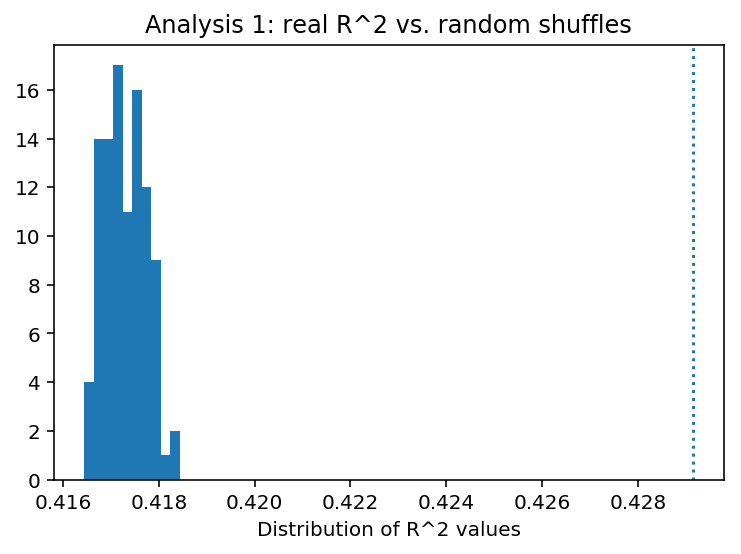

In [44]:
plt.hist(shuffled_rsquares)
plt.axvline(x=true_rsquare, linestyle="dotted")
plt.xlabel("Distribution of R^2 values")
plt.title("Analysis 1: real R^2 vs. random shuffles")

## Analysis 2: `AoA impact ~ onset`

In our second analysis, we attempt to control for the rest of the word in a different way. We first identify all of the minimal sets in the lexicon differing only by the first sound, e.g., {hug, bug, ...}. For each set, we calculate the **mean AoA**. We then define the **AoA impact** of each onset phone differentiating the words in the set as the difference between the word beginning with that onset and the mean AoA, e.g.,:

**Impact(h) = AOA(hug) - mean(AOA(hug, AOA(bug)...)**

We repeat this for each minimal set, such that any given onset phone has a distribution of associated **AOA impact scores**. As above, we then regress impact against **onset phone**. 

### Get minimal pairs

In [125]:
df_monosyllabic['coda'] = df_monosyllabic['PhonDISC'].apply(lambda x: x[1:])

/Users/seantrott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [126]:
df_coda_means = df_monosyllabic.groupby('coda', as_index=False).mean()[['coda', 'AoA_mean']]
df_coda_means['set_mean'] = df_coda_means['AoA_mean']
df_coda_means = df_coda_means[['coda', 'set_mean']]
df_coda_means.head(5)

,coda,set_mean
0,,5.105000
1,#,4.475000
2,#D@R,6.366667
3,#DIN,12.670000
4,#J,10.770000


In [127]:
df_joined = pd.merge(df_coda_means, df_monosyllabic, on = "coda")
len(df_joined)

11130

In [131]:
df_set_sizes = df_monosyllabic.groupby('coda', as_index=False).size()
df_joined['set_size'] = df_joined['coda'].apply(lambda x: df_set_sizes[x])

In [132]:
df_joined = df_joined[df_joined['set_size']>1]
len(df_joined)

3750

In [133]:
df_joined['aoa_impact'] = df_joined['AoA_mean'] - df_joined['set_mean']

In [134]:
df_joined.to_csv("data/processed/aoa_impacts.csv")

### Characterization

In [135]:
df_joined = pd.read_csv("data/processed/aoa_impacts.csv") 

In [136]:
len(df_joined)

3750

Text(0, 0.5, 'Count')

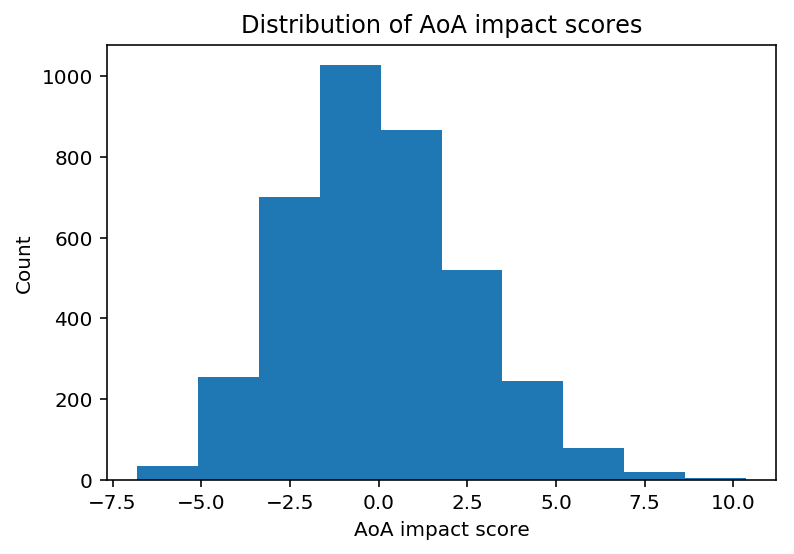

In [137]:
plt.hist(df_joined['aoa_impact'])
plt.title("Distribution of AoA impact scores")
plt.xlabel("AoA impact score")
plt.ylabel("Count")

In [138]:
print("Skew: {s}".format(s=ss.stats.skew(df_joined['aoa_impact'])))
print("Mean: {m}".format(m=np.mean(df_joined['aoa_impact'])))
print("SD: {sd}".format(sd=np.std(df_joined['aoa_impact'])))
print("Median: {sd}".format(sd=np.median(df_joined['aoa_impact'])))

Skew: 0.3815187434207911
Mean: -2.1079434494216304e-17
SD: 2.4975293712193714
Median: -0.16999999999999993


### Characterization

Now, we do a similar analysis as before, but predicting the **impact** on AoA.

In [146]:
df_joined.head(5)

,Unnamed: 0,coda,set_mean,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,OccurTotal,OccurNum,Freq_pm,Rating.Mean,Rating.SD,Dunno,AoA_mean,onset,word_length,aoa_impact,set_size
0,0,NaN,5.105,a,4.36,1,1,ART,1,22.0,22.0,20415.27,2.89,1.21,1.0,2.89,1,1,-2.215,4
1,1,NaN,5.105,awe,0.90,1,$,N,1,18.0,18.0,2.63,9.06,3.87,1.0,9.06,$,1,3.955,4
2,2,NaN,5.105,eye,2.72,1,2,N,1,20.0,20.0,111.78,3.75,1.71,1.0,3.75,2,1,-1.355,4
3,3,NaN,5.105,oh,2.66,0,5,I,1,20.0,20.0,3289.82,4.72,1.85,1.0,4.72,5,1,-0.385,4
4,4,#,4.475,ma,0.78,1,m#,N,1,20.0,20.0,185.80,4.35,2.74,1.0,4.35,m,2,-0.125,2


In [151]:
result = sm.ols(formula="aoa_impact ~ onset + set_mean + word_length + set_size", data=df_joined).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             aoa_impact   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.938
Date:                Sat, 18 Jan 2020   Prob (F-statistic):           0.000287
Time:                        15:45:16   Log-Likelihood:                -8712.7
No. Observations:                3750   AIC:                         1.751e+04
Df Residuals:                    3707   BIC:                         1.778e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.3222      0.730      0.441      0.659      -1.110       1.754
onset[T.$]      0.3996      0.885      0.451      0.652      -1.336       2.136
onset[T.1]     -0.1456      0.904     -0.161      0.872      -1.919       1.628
onset[T.2]     -0.9087      0.942     -0.965      0.335      -2.755       0.938
onset[T.3]      1.9996      1.018      1.964      0.050       0.003       3.996
onset[T.4]     -1.2998      1.592     -0.816      0.414      -4.422       1.822
onset[T.5]      1.2852      0.877      1.466      0.143      -0.434       3.005
onset[T.6]     -1.5310      1.308     -1.170      0.242      -4.096       1.034
onset[T.7]     -1.8805      1.888     -0.996      0.319      -5.581       1.820
onset[T.8]     -3.3923      1.888     -1.797      0.072      -7.093       0.308
onset[T.@]      0.1944      0.835      0.233      0.816      -1.443       1.832
onset[T.D]     -0.9979      0.978     -1.020      0.308      -2.916       0.920
onset[T.E]     -0.8756      0.916     -0.956      0.339      -2.671       0.920
onset[T.I]     -0.5521      0.864     -0.639      0.523      -2.246       1.141
onset[T.J]     -0.2294      0.747     -0.307      0.759      -1.695       1.236
onset[T.Q]     -1.9919      0.975     -2.043      0.041      -3.904      -0.080
onset[T.S]     -0.3628      0.736     -0.493      0.622      -1.805       1.080
onset[T.T]     -0.0129      0.773     -0.017      0.987      -1.528       1.503
onset[T.V]     -1.2456      1.047     -1.190      0.234      -3.298       0.806
onset[T._]     -0.0424      0.746     -0.057      0.955      -1.506       1.421
onset[T.b]     -0.6382      0.707     -0.903      0.366      -2.023       0.747
onset[T.d]     -0.1361      0.713     -0.191      0.849      -1.534       1.262
onset[T.f]     -0.4308      0.710     -0.607      0.544      -1.823       0.961
onset[T.g]      0.0240      0.717      0.034      0.973      -1.381       1.429
onset[T.h]     -0.6865      0.717     -0.957      0.339      -2.093       0.720
onset[T.i]     -0.0005      0.957     -0.000      1.000      -1.877       1.876
onset[T.j]     -0.0107      0.810     -0.013      0.989      -1.600       1.578
onset[T.k]     -0.2970      0.707     -0.420      0.674      -1.683       1.089
onset[T.l]     -0.0899      0.717     -0.125      0.900      -1.495       1.315
onset[T.m]     -0.5177      0.713     -0.726      0.468      -1.915       0.880
onset[T.n]     -0.1810      0.733     -0.247      0.805      -1.619       1.257
onset[T.p]     -0.3020      0.707     -0.427      0.669      -1.689       1.085
onset[T.r]     -0.0098      0.713     -0.014      0.989      -1.407       1.388
onset[T.s]     -0.4124      0.709     -0.582      0.561      -1.802       0.977
onset[T.t]     -0.3476      0.712     -0.488      0.625      -1.743       1.047
onset[T.u]      0.6498      2.579      0.25

In [148]:
### Shuffling
shuffled_rsquares = []
true_rsquare = result.rsquared

NUM_SHUFFLES = 100

for shuffle in tqdm(range(NUM_SHUFFLES)):
    new_df = df_joined.copy()
    new_df['shuffled_onset'] = np.random.permutation(new_df['onset'])
    new_result = sm.ols(formula="aoa_impact ~ shuffled_onset + set_mean + word_length + set_size", data=new_df).fit()
    shuffled_rsquares.append(new_result.rsquared)

100%|██████████| 100/100 [00:03<00:00, 29.05it/s]


In [149]:
shuffled_rsquares_np = np.array(shuffled_rsquares)
print(np.mean(shuffled_rsquares_np))
print(np.std(shuffled_rsquares_np))

0.010299962959787332
0.002589662951319239


Text(0.5, 1.0, 'Analysis 2: real R^2 vs. random shuffles')

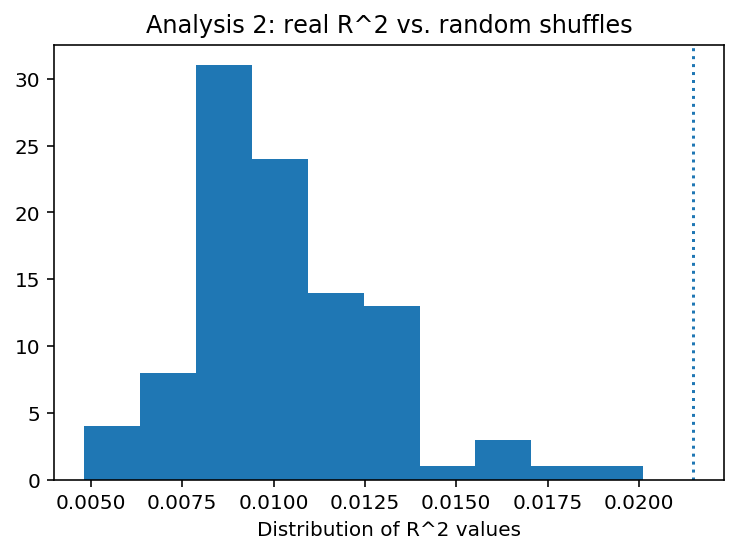

In [150]:
plt.hist(shuffled_rsquares)
plt.axvline(x=true_rsquare, linestyle="dotted")
plt.xlabel("Distribution of R^2 values")
plt.title("Analysis 2: real R^2 vs. random shuffles")